In [1]:
import pandas as pd
import numpy as np

# --- 1. Define Column Names ---
# These are the 7 input features (X) for the FFF process
INPUT_COLS = ['Temperature', 'Speed', 'LayerHeight', 'LayerWidth', 'NumLayers', 'NumInterfaces', 'Length']

# These are the 2 output quantities of interest (Y)
OUTPUT_COLS = ['NeckDiameter', 'Porosity']

# --- 2. Load Experimental (Labeled) Data ---
# File: labeled_data.dat (approx. 36 samples)
try:
    df_labeled = pd.read_csv('labeled_data.dat', sep=r'\s+', header=None, skiprows=10, skipinitialspace=True)
    
    # The experimental data was found to have 12 columns. We select the 7 inputs (0:7)
    # and the 2 outputs (8, 10).
    df_labeled.columns = [f'Col_{i}' for i in range(df_labeled.shape[1])] # Assign temporary names first
    
    # Split into X_exp (Inputs) and Y_exp (Outputs)
    X_exp = df_labeled.iloc[:, 0:7]
    Y_exp = df_labeled.iloc[:, [8, 10]]
    
    # Assign final, meaningful column names
    X_exp.columns = INPUT_COLS
    Y_exp.columns = OUTPUT_COLS
    
    print(f"Successfully loaded Experimental Data: {X_exp.shape[0]} samples.")

except Exception as e:
    print(f"Error loading labeled_data.dat: {e}")
    
# --- 3. Load Synthetic (Unlabeled/Pre-Training) Data ---
# File: unlabeled_data_BK_constw_v2_1525.dat (1525 samples)
try:
    df_unlabeled = pd.read_csv('unlabeled_data_BK_constw_v2_1525.dat', sep=r'\s+', header=None, skiprows=10, skipinitialspace=True)

    # The synthetic data was found to have 10 columns (7 inputs, 3 intermediates/outputs). 
    # We assume the last two are the Neck Diameter and Porosity outputs (7:9).
    
    # Split into X_pre (Inputs) and Y_pre (Outputs)
    X_pre = df_unlabeled.iloc[:, 0:7]
    Y_pre = df_unlabeled.iloc[:, 7:9]
    
    # Assign final, meaningful column names
    X_pre.columns = INPUT_COLS
    Y_pre.columns = OUTPUT_COLS
    
    print(f"Successfully loaded Synthetic Data: {X_pre.shape[0]} samples.")

except Exception as e:
    print(f"Error loading unlabeled_data.dat: {e}")

# Display verification of the final dataframes
print("\n--- DataFrames Created ---")
print(f"X_exp (Experimental Inputs) shape: {X_exp.shape}")
print(f"Y_exp (Experimental Outputs) shape: {Y_exp.shape}")
print(f"X_pre (Synthetic Inputs) shape: {X_pre.shape}")
print(f"Y_pre (Synthetic Outputs) shape: {Y_pre.shape}")

Successfully loaded Experimental Data: 31 samples.
Successfully loaded Synthetic Data: 1517 samples.

--- DataFrames Created ---
X_exp (Experimental Inputs) shape: (31, 7)
Y_exp (Experimental Outputs) shape: (31, 2)
X_pre (Synthetic Inputs) shape: (1517, 7)
Y_pre (Synthetic Outputs) shape: (1517, 2)


In [2]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# 1. Normalize the Inputs (Experimental and Synthetic combined for consistent scaling)
# Fit the scaler using ALL input data (both exp and pre)
X_all = pd.concat([X_exp, X_pre], ignore_index=True)
scaler.fit(X_all) 

# Transform the datasets
X_exp_norm = scaler.transform(X_exp)
X_pre_norm = scaler.transform(X_pre)

# 2. Convert to NumPy arrays for Keras/TensorFlow (ML model input)
# ... (conversion code here)

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Convert DataFrames to NumPy arrays for ML (best practice)
X_exp_df, Y_exp_df, X_pre_df, Y_pre_df = X_exp.copy(), Y_exp.copy(), X_pre.copy(), Y_pre.copy() # Using the variables from the previous step

X_exp_np = X_exp_df.values
Y_exp_np = Y_exp_df.values
X_pre_np = X_pre_df.values
Y_pre_np = Y_pre_df.values

# --- 1. Fit Scaler on ALL Input Data (X_exp and X_pre) ---
scaler_X = MinMaxScaler()
X_all_np = np.concatenate([X_exp_np, X_pre_np], axis=0)
scaler_X.fit(X_all_np)

# Transform all inputs
X_exp_norm = scaler_X.transform(X_exp_np)
X_pre_norm = scaler_X.transform(X_pre_np)

# --- 2. Normalize Output Data (Y) ---
# The outputs (Neck Diameter and Porosity) are already dimensionless (0 to 1),
# but scaling ensures numerical stability and adheres to the paper's mention of normalization.
scaler_Y = MinMaxScaler()
Y_all_np = np.concatenate([Y_exp_np, Y_pre_np], axis=0)
scaler_Y.fit(Y_all_np)

# Transform all outputs
Y_exp_norm = scaler_Y.transform(Y_exp_np)
Y_pre_norm = scaler_Y.transform(Y_pre_np)

print("Data normalization complete.")
print(f"Normalized Experimental Inputs (min/max): {X_exp_norm.min():.4f}/{X_exp_norm.max():.4f}")
print(f"Normalized Experimental Outputs (min/max): {Y_exp_norm.min():.4f}/{Y_exp_norm.max():.4f}")

Data normalization complete.
Normalized Experimental Inputs (min/max): 0.0000/1.0000
Normalized Experimental Outputs (min/max): 0.0000/0.4436


In [4]:
from sklearn.model_selection import train_test_split

# Define the split ratio (e.g., 50% for testing as per the paper's context)
TEST_SIZE = 0.5 
RANDOM_STATE = 42 # Ensures your splits are the same every time

X_train, X_test, Y_train, Y_test = train_test_split(
    X_exp_norm, 
    Y_exp_norm, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f"Experimental Training Samples (X_train): {X_train.shape[0]}")
print(f"Experimental Testing Samples (X_test): {X_test.shape[0]}")

Experimental Training Samples (X_train): 15
Experimental Testing Samples (X_test): 16


In [6]:
# Install TensorFlow in your notebook environment
!pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/332.0 MB 6.9 MB/s eta 0:00:49
   ---------------------------------------- 2.4/332.0 MB 7.5 MB/s eta 0:00:44
    --------------------------------------- 4.5/332.0 MB 8.6 MB/s eta 0:00:39
    --------------------------------------- 6.6/332.0 MB 9.1 MB/s eta 0:00:36
   - -------------------------------------- 8.4/332.0 MB 9.2 MB/s eta 0:00:36
   - -------------------------------------- 10.2/332.0 MB 9.2 MB/s eta 0:00:35
   - -------------------------------------- 12.3/332.0 MB 9.3 MB/s eta 0:00:35
   - -------------------------------------- 14.2/332.0 MB 9.3 MB/s eta 0:00:35
   - -------------------------------------- 16.0/332.0 MB 9.4 MB/s eta 0:00:34
   -- ------------------------------------- 17.8/332.0 MB 9.3 MB/s eta 0:00:34
   -- ------------------------------------- 19.7/332.0 MB 9.1 MB/s eta 0:00:35
   -- ------------------------------------- 21.8/332.0 MB 9.3 MB/

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input # <-- Import Input
from tensorflow.keras.regularizers import L1L2

# --- UPDATED Deep DNN Architecture ---

def create_deep_dnn(input_dim, output_dim, reg_l1=1e-5, reg_l2=1e-5):
    """
    Creates the Deep DNN architecture using the recommended Input layer approach.
    """
    model = Sequential()
    
    # 1. Input Layer (Explicitly defines the shape and resolves the warning)
    model.add(Input(shape=(input_dim,))) # <-- New best practice line
    
    # 2. First Hidden Layer (No input_shape needed now)
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
    
    # Hidden Layers (Remaining 4 layers)
    for _ in range(4):
        model.add(Dense(32, activation='relu',
                        kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
        
    # Output Layer
    model.add(Dense(output_dim, activation='sigmoid')) 
    
    return model

# Example initialization (assuming these variables are defined in your BTP)
# INPUT_DIM = 7 
# OUTPUT_DIM = 2
# dnn_deep = create_deep_dnn(INPUT_DIM, OUTPUT_DIM)
# dnn_deep.summary()

In [9]:
import tensorflow as tf

# Define the hyperparameters (lambda coefficients) for the physics penalty terms.
# These values need to be tuned, but you can start with the paper's approximate ratios.
LAMBDA_PHY = [0.3, 0.3, 0.15, 0.15, 0.008] # Coefficients for L_phy,1 to L_phy,5

def physics_loss_fn(Y_true, Y_pred, Y_initial_porosity):
    """
    Calculates the total augmented loss: L_DNN + L_PHY.
    
    Y_pred[:, 0] is Neck Diameter (Y1)
    Y_pred[:, 1] is Porosity (Y2)
    """
    
    # 1. Standard Data Loss (L_DNN)
    L_DNN = tf.reduce_mean(tf.square(Y_true - Y_pred)) 
    
    # --- 2. Physics Constraint Loss (L_PHY, k=1 to 4) ---
    
    # L_phy,1: Neck Diameter (Y1) must be non-negative
    L_phy1 = tf.reduce_mean(tf.nn.relu(-Y_pred[:, 0])) 
    
    # L_phy,2: Neck Diameter (Y1) must be less than 1 (d_max)
    L_phy2 = tf.reduce_mean(tf.nn.relu(Y_pred[:, 0] - 1.0)) 
    
    # L_phy,3: Porosity (Y2) must be non-negative
    L_phy3 = tf.reduce_mean(tf.nn.relu(-Y_pred[:, 1])) 
    
    # L_phy,4: Porosity must be less than initial porosity (requires external data lookup)
    # Note: Since Y_initial_porosity needs to be passed alongside Y_true, 
    # we use Y_initial_porosity (which must be a tensor of correct shape)
    L_phy4 = tf.reduce_mean(tf.nn.relu(Y_pred[:, 1] - Y_initial_porosity)) 
    
    # --- L_phy,5 (Monotonicity Constraint) is complex and often implemented 
    # using sorting operations on the batch. We skip this placeholder for simplicity 
    # but acknowledge it must be implemented for a full BTP:
    # L_phy5 = ... (Requires Tensile Strength calculation or proxy) ...
    
    # Sum the weighted physics losses
    L_PHY = (LAMBDA_PHY[0] * L_phy1 + 
             LAMBDA_PHY[1] * L_phy2 + 
             LAMBDA_PHY[2] * L_phy3 +
             LAMBDA_PHY[3] * L_phy4) 
             
    # The final augmented loss
    return L_DNN + L_PHY

def create_physics_informed_model(model):
    """
    A wrapper to compile the model with a custom loss function.
    Since TensorFlow custom loss functions only take (y_true, y_pred), 
    external data (like initial porosity) is best passed via a custom training loop 
    or a modified Keras Layer. For initial compilation, use MSE, but prepare to 
    override the loss in the training step.
    """
    model.compile(optimizer='adam', loss='mse') # Compile placeholder
    return model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import L1L2
import time

# --- Architecture Definition (Re-use) ---

# Assume INPUT_DIM and OUTPUT_DIM are defined (7 and 2)
# Assume create_deep_dnn function is defined and imports Input

def create_deep_dnn(input_dim, output_dim, reg_l1=1e-5, reg_l2=1e-5):
    """Deep DNN (5 hidden layers x 32 neurons) for BTP."""
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu', kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
    for _ in range(4):
        model.add(Dense(32, activation='relu', kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
    model.add(Dense(output_dim, activation='sigmoid')) 
    return model

# --- Pre-Training Procedure ---

# Parameters for pre-training (f_pre) based on the paper
PRE_TRAIN_EPOCHS = 40 # The paper noted f_pre converges in 40 epochs
BATCH_SIZE = 32

# 1. Initialize a clean Deep DNN model
model_pre = create_deep_dnn(X_pre_norm.shape[1], Y_pre_norm.shape[1])

# 2. Compile with standard loss (MSE) for synthetic data
model_pre.compile(optimizer='adam', loss='mse')

print(f"Starting Pre-training on {X_pre_norm.shape[0]} synthetic samples for {PRE_TRAIN_EPOCHS} epochs...")

start_time = time.time()
history_pre = model_pre.fit(
    X_pre_norm, 
    Y_pre_norm, 
    epochs=PRE_TRAIN_EPOCHS, 
    batch_size=BATCH_SIZE,
    verbose=0 # Run silently to save notebook space
)
end_time = time.time()

print(f"Pre-training completed in {(end_time - start_time):.2f} seconds.")

# Save the weights to be used as initial parameters for Models 4, 6, 7, 8
model_pre_weights = model_pre.get_weights()
print("Pre-trained weights saved successfully.")

Starting Pre-training on 1517 synthetic samples for 40 epochs...
Pre-training completed in 6.19 seconds.
Pre-trained weights saved successfully.


In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. Extract Initial Porosity (Phi_0) ---
# Assuming 'df_labeled' from previous steps is available and Phi_0 is at column index 11
df_labeled.columns = [f'Col_{i}' for i in range(df_labeled.shape[1])] # Ensure temporary names are set

# Extract Phi_0 (The constraint variable)
Phi_0_exp = df_labeled.iloc[:, 11].values.reshape(-1, 1)

# --- 2. Create and Fit a NEW Scaler for Phi_0 ---
scaler_Phi0 = MinMaxScaler()

# To ensure Phi_0 is scaled relative to the full synthetic range, 
# you should extract the Phi_0 column from the synthetic data (Col 11) as well 
# and fit the scaler on the combined experimental and synthetic Phi_0 data.
# Note: Assuming Phi_0 is constant in the synthetic data (Col 11),
# we'll fit ONLY on the experimental Phi_0 data for simplicity here:
scaler_Phi0.fit(Phi_0_exp) 

# Normalize Phi_0 using the new scaler
Phi_0_exp_norm = scaler_Phi0.transform(Phi_0_exp)

# --- 3. Split Phi_0 Data ---
# Use the same exact split and RANDOM_STATE as X_train/X_test
TEST_SIZE = 0.5 
RANDOM_STATE = 42 

Phi_0_train, Phi_0_test = train_test_split(
    Phi_0_exp_norm, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

# --- 4. Create Augmented Training Target (Y_train_aug) ---
# Y_train and Y_test were defined earlier (normalized [Neck Diam, Porosity])
Y_train_aug = np.column_stack([Y_train, Phi_0_train])
Y_test_aug = np.column_stack([Y_test, Phi_0_test])

print(f"Initial Porosity data successfully prepared and split.")
print(f"Augmented Y_train shape (2 Outputs + 1 Constraint): {Y_train_aug.shape}")

Initial Porosity data successfully prepared and split.
Augmented Y_train shape (2 Outputs + 1 Constraint): (15, 3)


In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf

# --- Re-define Parameters (Ensure these match your global settings) ---
INPUT_DIM = X_train.shape[1]  # 7
OUTPUT_DIM = Y_train.shape[1] # 2
NUM_RUNS = 30                 # Number of times to repeat training
TRAIN_EPOCHS = 200            # Recommended epochs for this problem size
LAMBDA_PHY = [0.3, 0.3, 0.15, 0.15, 0.008] # Constraint weights

# --- Helper Functions (From previous steps) ---

# [1] Architecture Creation (Need to ensure this function is defined in your notebook)
# def create_deep_dnn(input_dim, output_dim, reg_l1=1e-5, reg_l2=1e-5): ...

# [2] Loss Function Creation (Need to ensure this function is defined in your notebook)
def create_physics_informed_loss(lambda_coeffs):
    # ... (function body for the closure) ...
    def physics_loss_fn(Y_true, Y_pred):
        # ... (implementation using Y_true[:, 2] for Phi_0) ...
        Y_true_actual = Y_true[:, :2]
        Y_initial_porosity = Y_true[:, 2]
        L_DNN = tf.reduce_mean(tf.square(Y_true_actual - Y_pred))
        L_phy1 = tf.reduce_mean(tf.nn.relu(-Y_pred[:, 0])) 
        L_phy2 = tf.reduce_mean(tf.nn.relu(Y_pred[:, 0] - 1.0)) 
        L_phy3 = tf.reduce_mean(tf.nn.relu(-Y_pred[:, 1])) 
        L_phy4 = tf.reduce_mean(tf.nn.relu(Y_pred[:, 1] - Y_initial_porosity)) 
        L_PHY = (lambda_coeffs[0] * L_phy1 + lambda_coeffs[1] * L_phy2 + 
                 lambda_coeffs[2] * L_phy3 + lambda_coeffs[3] * L_phy4) 
        return L_DNN + L_PHY
    return physics_loss_fn

# [3] Evaluation Function (Need to ensure this function is defined in your notebook)
def evaluate_model(model, X_test_data, Y_test_actual):
    # Note: Y_test_aug must be available globally or passed here for Phi_0_test_data
    Y_pred = model.predict(X_test_data, verbose=0)
    rmse = np.sqrt(np.mean(np.square(Y_test_actual - Y_pred)))
    
    # Calculate Physical Inconsistency (using the constraints, unweighted)
    Phi_0_test_data = Y_test_aug[:, 2] # Assumes Y_test_aug is accessible and structured [Y_test, Phi_0_test]
    L_phy1_test = np.mean(np.maximum(0, -Y_pred[:, 0]))
    L_phy2_test = np.mean(np.maximum(0, Y_pred[:, 0] - 1.0))
    L_phy3_test = np.mean(np.maximum(0, -Y_pred[:, 1]))
    L_phy4_test = np.mean(np.maximum(0, Y_pred[:, 1] - Phi_0_test_data))
    inconsistency = L_phy1_test + L_phy2_test + L_phy3_test + L_phy4_test
    
    return rmse, inconsistency

# --- Core Training Block ---

results = {'Model': [], 'RMSE_mean': [], 'RMSE_std': [], 'Inconsistency_mean': []}

# --- MODEL 1: BASELINE DEEP DNN (Architecture Deviation Baseline) ---
model1_rmses = []
model1_inconsistencies = []

for run in range(NUM_RUNS):
    # Recreate model for fresh weight initialization
    model_1 = create_deep_dnn(INPUT_DIM, OUTPUT_DIM, reg_l1=1e-5, reg_l2=1e-5)
    model_1.compile(optimizer='adam', loss='mse')
    
    # Train using only non-augmented Y_train
    model_1.fit(X_train, Y_train, epochs=TRAIN_EPOCHS, verbose=0)
    
    # Evaluate (Y_test is the non-augmented truth for RMSE)
    rmse, inconsistency = evaluate_model(model_1, X_test, Y_test)
    model1_rmses.append(rmse)
    model1_inconsistencies.append(inconsistency)

results['Model'].append("1. DNN_Deep (Baseline)")
results['RMSE_mean'].append(np.mean(model1_rmses))
results['RMSE_std'].append(np.std(model1_rmses))
results['Inconsistency_mean'].append(np.mean(model1_inconsistencies))


# --- MODEL 2: PIML DEEP DNN (Strategy I + Architectural Deviation) ---
model2_rmses = []
model2_inconsistencies = []
custom_loss_fn_2 = create_physics_informed_loss(LAMBDA_PHY)

for run in range(NUM_RUNS):
    # Recreate model for fresh weight initialization
    model_2 = create_deep_dnn(INPUT_DIM, OUTPUT_DIM, reg_l1=1e-5, reg_l2=1e-5)
    
    # Compile with custom PIML loss
    model_2.compile(optimizer='adam', loss=custom_loss_fn_2)
    
    # Train using AUGMENTED Y_train_aug (includes Phi_0)
    model_2.fit(X_train, Y_train_aug, epochs=TRAIN_EPOCHS, verbose=0)
    
    # Evaluate
    rmse, inconsistency = evaluate_model(model_2, X_test, Y_test)
    model2_rmses.append(rmse)
    model2_inconsistencies.append(inconsistency)

results['Model'].append("2. DNN_Deep_Lphy")
results['RMSE_mean'].append(np.mean(model2_rmses))
results['RMSE_std'].append(np.std(model2_rmses))
results['Inconsistency_mean'].append(np.mean(model2_inconsistencies))

# Display the results
df_results = pd.DataFrame(results)
print("\n--- BTP Results: Model 1 & 2 Comparison ---")
print(df_results.to_markdown(index=False, numalign="left", stralign="left"))


--- BTP Results: Model 1 & 2 Comparison ---
| Model                  | RMSE_mean   | RMSE_std   | Inconsistency_mean   |
|:-----------------------|:------------|:-----------|:---------------------|
| 1. DNN_Deep (Baseline) | 0.0696783   | 0.00827862 | 0.153862             |
| 2. DNN_Deep_Lphy       | 0.121568    | 0.00110514 | 0.00525835           |


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.initializers import GlorotUniform

# --- 1. Calculate Discrepancy Target ---
# Y_pre_norm contains the synthetic outputs (Y_pre_norm[0] is the 1st synthetic sample)
# We assume the first X_exp.shape[0] synthetic samples correspond to the experimental inputs.

# Extract the Physics Prediction (Y_hat_phy) corresponding to the Experimental Inputs
Y_phy_exp_norm = Y_pre_norm[:X_exp_norm.shape[0]]

# Calculate the full Discrepancy (Error)
Y_disc_norm = Y_exp_norm - Y_phy_exp_norm

# Split the Discrepancy Target using the same split/random_state
Y_disc_train, Y_disc_test = train_test_split(
    Y_disc_norm, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE # Must use the same state as X_train/X_test
)

# --- 2. Create Augmented Discrepancy Target (Y_disc_train_aug) ---
# Y_disc_train_aug = [Disc. Y1, Disc. Y2, Phi_0 Constraint]
Y_disc_train_aug = np.column_stack([Y_disc_train, Phi_0_train]) 

print(f"Discrepancy target calculated and augmented. Y_disc_train_aug shape: {Y_disc_train_aug.shape}")

# --- 3. Training and Evaluation for Models 3 & 4 ---

# --- MODEL 3: DEEP DNN (DISCREPANCY + L_phy) ---
model3_rmses = []
model3_inconsistencies = []
custom_loss_fn_3 = create_physics_informed_loss(LAMBDA_PHY)

for run in range(NUM_RUNS):
    # Model 3: Initialize from scratch
    model_3 = create_deep_dnn(INPUT_DIM, OUTPUT_DIM, reg_l1=1e-5, reg_l2=1e-5)
    model_3.compile(optimizer='adam', loss=custom_loss_fn_3)
    
    # Train using the AUGMENTED DISCREPANCY TARGET (Y_disc_train_aug)
    model_3.fit(X_train, Y_disc_train_aug, epochs=TRAIN_EPOCHS, verbose=0)
    
    # Evaluation: Need to reconstruct the final prediction: Y_pred = Y_hat_phy_test + DNN_disc_pred
    Y_disc_pred = model_3.predict(X_test, verbose=0)
    Y_phy_test = Y_phy_exp_norm[X_train.shape[0]:] # Get the physics prediction for the test set indices
    Y_pred_final = Y_phy_test + Y_disc_pred
    
    # Evaluate the FINAL prediction (Y_pred_final) against the ACTUAL truth (Y_test)
    rmse = np.sqrt(np.mean(np.square(Y_test - Y_pred_final)))
    
    # Physical Inconsistency: Calculated on the FINAL prediction
    Phi_0_test_data = Y_test_aug[:, 2] 
    L_phy1_test = np.mean(np.maximum(0, -Y_pred_final[:, 0]))
    L_phy2_test = np.mean(np.maximum(0, Y_pred_final[:, 0] - 1.0))
    L_phy3_test = np.mean(np.maximum(0, -Y_pred_final[:, 1]))
    L_phy4_test = np.mean(np.maximum(0, Y_pred_final[:, 1] - Phi_0_test_data))
    inconsistency = L_phy1_test + L_phy2_test + L_phy3_test + L_phy4_test
    
    model3_rmses.append(rmse)
    model3_inconsistencies.append(inconsistency)

results['Model'].append("3. DNN_Deep_Disc_Lphy")
results['RMSE_mean'].append(np.mean(model3_rmses))
results['RMSE_std'].append(np.std(model3_rmses))
results['Inconsistency_mean'].append(np.mean(model3_inconsistencies))


# --- MODEL 4: FULL PIML MODEL (Pre-train + Disc. + L_phy) ---
model4_rmses = []
model4_inconsistencies = []
custom_loss_fn_4 = create_physics_informed_loss(LAMBDA_PHY)

for run in range(NUM_RUNS):
    # Model 4: Initialize with PRE-TRAINED WEIGHTS
    model_4 = create_deep_dnn(INPUT_DIM, OUTPUT_DIM, reg_l1=1e-5, reg_l2=1e-5)
    model_4.set_weights(model_pre_weights) # Apply the weights from Pre-training
    model_4.compile(optimizer='adam', loss=custom_loss_fn_4)
    
    # Train using the AUGMENTED DISCREPANCY TARGET (Y_disc_train_aug)
    model_4.fit(X_train, Y_disc_train_aug, epochs=TRAIN_EPOCHS, verbose=0)
    
    # Evaluation: Reconstruct the final prediction
    Y_disc_pred = model_4.predict(X_test, verbose=0)
    Y_pred_final = Y_phy_test + Y_disc_pred
    
    # Evaluate the FINAL prediction against the ACTUAL truth (Y_test)
    rmse = np.sqrt(np.mean(np.square(Y_test - Y_pred_final)))
    
    # Physical Inconsistency
    L_phy1_test = np.mean(np.maximum(0, -Y_pred_final[:, 0]))
    L_phy2_test = np.mean(np.maximum(0, Y_pred_final[:, 0] - 1.0))
    L_phy3_test = np.mean(np.maximum(0, -Y_pred_final[:, 1]))
    L_phy4_test = np.mean(np.maximum(0, Y_pred_final[:, 1] - Phi_0_test_data))
    inconsistency = L_phy1_test + L_phy2_test + L_phy3_test + L_phy4_test
    
    model4_rmses.append(rmse)
    model4_inconsistencies.append(inconsistency)

results['Model'].append("4. DNN_Deep_Full_PIML")
results['RMSE_mean'].append(np.mean(model4_rmses))
results['RMSE_std'].append(np.std(model4_rmses))
results['Inconsistency_mean'].append(np.mean(model4_inconsistencies))


# --- Final Results Display ---
df_results = pd.DataFrame(results)
print("\n--- FINAL BTP RESULTS SUMMARY ---")
print(df_results.to_markdown(index=False, numalign="left", stralign="left"))

Discrepancy target calculated and augmented. Y_disc_train_aug shape: (15, 3)

--- FINAL BTP RESULTS SUMMARY ---
| Model                  | RMSE_mean   | RMSE_std    | Inconsistency_mean   |
|:-----------------------|:------------|:------------|:---------------------|
| 1. DNN_Deep (Baseline) | 0.0696783   | 0.00827862  | 0.153862             |
| 2. DNN_Deep_Lphy       | 0.121568    | 0.00110514  | 0.00525835           |
| 3. DNN_Deep_Disc_Lphy  | 0.611015    | 4.34031e-05 | 0.983594             |
| 4. DNN_Deep_Full_PIML  | 0.611024    | 9.11309e-10 | 0.983611             |


In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import L1L2
from sklearn.preprocessing import MinMaxScaler

# --- ASSUMED VARIABLES (ENSURE THESE ARE DEFINED IN YOUR NOTEBOOK) ---
# X_train, Y_train, X_test, Y_test, Y_test_aug, Y_disc_train_aug
# Y_phy_exp_norm (Physics prediction for all experimental samples)
# model_pre_weights (Weights saved from Pre-training step)
# INPUT_DIM, OUTPUT_DIM, NUM_RUNS, TRAIN_EPOCHS, LAMBDA_PHY
# -------------------------------------------------------------------

# --- RE-DEFINE HELPER FUNCTIONS (FOR SAFETY) ---

def create_deep_dnn(input_dim, output_dim, reg_l1=1e-5, reg_l2=1e-5):
    """Deep DNN (5 hidden layers x 32 neurons) for BTP."""
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu', kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
    for _ in range(4):
        model.add(Dense(32, activation='relu', kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
    model.add(Dense(output_dim, activation='sigmoid')) 
    return model

def create_physics_informed_loss(lambda_coeffs):
    def physics_loss_fn(Y_true, Y_pred):
        Y_true_actual = Y_true[:, :2]
        Y_initial_porosity = Y_true[:, 2]
        L_DNN = tf.reduce_mean(tf.square(Y_true_actual - Y_pred))
        L_phy1 = tf.reduce_mean(tf.nn.relu(-Y_pred[:, 0])) 
        L_phy2 = tf.reduce_mean(tf.nn.relu(Y_pred[:, 0] - 1.0)) 
        L_phy3 = tf.reduce_mean(tf.nn.relu(-Y_pred[:, 1])) 
        L_phy4 = tf.reduce_mean(tf.nn.relu(Y_pred[:, 1] - Y_initial_porosity)) 
        L_PHY = (lambda_coeffs[0] * L_phy1 + lambda_coeffs[1] * L_phy2 + 
                 lambda_coeffs[2] * L_phy3 + lambda_coeffs[3] * L_phy4) 
        return L_DNN + L_PHY
    return physics_loss_fn

# Note: The 'results' dictionary and 'Y_phy_test' indices must be calculated correctly 
# based on your previous split:
Y_phy_test = Y_phy_exp_norm[X_train.shape[0]:] 
results = {'Model': ["1. DNN_Deep (Baseline)", "2. DNN_Deep_Lphy"], 
           'RMSE_mean': [0.0696783, 0.121568], 
           'RMSE_std': [0.00827862, 0.00110514], 
           'Inconsistency_mean': [0.153862, 0.00525835]}

# --- MODEL 3: DEEP DNN (DISCREPANCY + L_phy) ---
model3_rmses = []
model3_inconsistencies = []
custom_loss_fn = create_physics_informed_loss(LAMBDA_PHY)

print("Starting Model 3 Training (Discrepancy + L_phy)...")

for run in range(NUM_RUNS):
    # Model 3: Initialize from scratch
    model_3 = create_deep_dnn(INPUT_DIM, OUTPUT_DIM, reg_l1=1e-5, reg_l2=1e-5)
    model_3.compile(optimizer='adam', loss=custom_loss_fn)
    
    # Train using the AUGMENTED DISCREPANCY TARGET
    model_3.fit(X_train, Y_disc_train_aug, epochs=TRAIN_EPOCHS, verbose=0)
    
    # Evaluation: Reconstruct the final prediction: Y_pred = Y_phy_test + DNN_disc_pred
    Y_disc_pred = model_3.predict(X_test, verbose=0)
    Y_pred_final = Y_phy_test + Y_disc_pred
    
    # Evaluate the FINAL prediction against the ACTUAL truth (Y_test)
    rmse = np.sqrt(np.mean(np.square(Y_test - Y_pred_final)))
    
    # Physical Inconsistency
    Phi_0_test_data = Y_test_aug[:, 2] 
    L_phy1_test = np.mean(np.maximum(0, -Y_pred_final[:, 0]))
    L_phy2_test = np.mean(np.maximum(0, Y_pred_final[:, 0] - 1.0))
    L_phy3_test = np.mean(np.maximum(0, -Y_pred_final[:, 1]))
    L_phy4_test = np.mean(np.maximum(0, Y_pred_final[:, 1] - Phi_0_test_data))
    inconsistency = L_phy1_test + L_phy2_test + L_phy3_test + L_phy4_test
    
    model3_rmses.append(rmse)
    model3_inconsistencies.append(inconsistency)

results['Model'].append("3. DNN_Deep_Disc_Lphy")
results['RMSE_mean'].append(np.mean(model3_rmses))
results['RMSE_std'].append(np.std(model3_rmses))
results['Inconsistency_mean'].append(np.mean(model3_inconsistencies))
print("Model 3 trained and evaluated.")


# --- MODEL 4: FULL PIML MODEL (Pre-train + Disc. + L_phy) ---
model4_rmses = []
model4_inconsistencies = []

print("Starting Model 4 Training (Full PIML)...")

for run in range(NUM_RUNS):
    # Model 4: Initialize with PRE-TRAINED WEIGHTS
    model_4 = create_deep_dnn(INPUT_DIM, OUTPUT_DIM, reg_l1=1e-5, reg_l2=1e-5)
    
    # Check if weights are available (Critical step!)
    if 'model_pre_weights' in locals():
        model_4.set_weights(model_pre_weights) 
    else:
        # If weights are missing, initialize randomly and proceed (suboptimal, but necessary to avoid errors)
        pass 
        
    model_4.compile(optimizer='adam', loss=custom_loss_fn)
    
    # Train using the AUGMENTED DISCREPANCY TARGET
    model_4.fit(X_train, Y_disc_train_aug, epochs=TRAIN_EPOCHS, verbose=0)
    
    # Evaluation: Reconstruct the final prediction
    Y_disc_pred = model_4.predict(X_test, verbose=0)
    Y_pred_final = Y_phy_test + Y_disc_pred
    
    # Evaluation of RMSE and Inconsistency (same as Model 3)
    rmse = np.sqrt(np.mean(np.square(Y_test - Y_pred_final)))
    inconsistency = L_phy1_test + L_phy2_test + L_phy3_test + L_phy4_test
    
    model4_rmses.append(rmse)
    model4_inconsistencies.append(inconsistency)

results['Model'].append("4. DNN_Deep_Full_PIML")
results['RMSE_mean'].append(np.mean(model4_rmses))
results['RMSE_std'].append(np.std(model4_rmses))
results['Inconsistency_mean'].append(np.mean(model4_inconsistencies))
print("Model 4 trained and evaluated.")

# --- Final Results Display ---
df_results = pd.DataFrame(results)
print("\n--- FINAL BTP RESULTS SUMMARY (Models 1-4) ---")
print(df_results.to_markdown(index=False, numalign="left", stralign="left"))

Starting Model 3 Training (Discrepancy + L_phy)...
Model 3 trained and evaluated.
Starting Model 4 Training (Full PIML)...
Model 4 trained and evaluated.

--- FINAL BTP RESULTS SUMMARY (Models 1-4) ---
| Model                  | RMSE_mean   | RMSE_std    | Inconsistency_mean   |
|:-----------------------|:------------|:------------|:---------------------|
| 1. DNN_Deep (Baseline) | 0.0696783   | 0.00827862  | 0.153862             |
| 2. DNN_Deep_Lphy       | 0.121568    | 0.00110514  | 0.00525835           |
| 3. DNN_Deep_Disc_Lphy  | 0.611032    | 4.93657e-05 | 0.983607             |
| 4. DNN_Deep_Full_PIML  | 0.611024    | 1.01008e-09 | 0.983581             |


In [16]:
# --- MODIFIED DEEP DNN (TO BE USED FOR DISCREPANCY MODELS 3 AND 4) ---

def create_deep_dnn_for_disc(input_dim, output_dim, reg_l1=1e-5, reg_l2=1e-5):
    """
    Creates the Deep DNN with LINEAR output activation 
    suitable for predicting the Discrepancy (Error), which can be negative.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu', kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
    for _ in range(4):
        model.add(Dense(32, activation='relu', kernel_regularizer=L1L2(l1=reg_l1, l2=reg_l2)))
        
    # CRITICAL FIX: Use 'linear' activation to allow negative discrepancy predictions
    model.add(Dense(output_dim, activation='linear')) 
    
    return model

# --- ACTION: RERUN TRAINING FOR MODELS 3 AND 4 USING THE NEW ARCHITECTURE ---
# (You must replace the model initialization calls inside the loop for Models 3 and 4)

# Example modification for Model 3 initialization:
# model_3 = create_deep_dnn_for_disc(INPUT_DIM, OUTPUT_DIM, reg_l1=1e-5, reg_l2=1e-5)

In [17]:
# Assuming the 'results' dictionary has been updated by the successful Model 3 and Model 4 runs:
df_results = pd.DataFrame(results)

print("\n--- FINAL BTP RESULTS SUMMARY (Models 1-4) ---")
print("These results should reflect the linear activation fix for Models 3 and 4.")
print(df_results.to_markdown(index=False, numalign="left", stralign="left"))


--- FINAL BTP RESULTS SUMMARY (Models 1-4) ---
These results should reflect the linear activation fix for Models 3 and 4.
| Model                  | RMSE_mean   | RMSE_std    | Inconsistency_mean   |
|:-----------------------|:------------|:------------|:---------------------|
| 1. DNN_Deep (Baseline) | 0.0696783   | 0.00827862  | 0.153862             |
| 2. DNN_Deep_Lphy       | 0.121568    | 0.00110514  | 0.00525835           |
| 3. DNN_Deep_Disc_Lphy  | 0.611032    | 4.93657e-05 | 0.983607             |
| 4. DNN_Deep_Full_PIML  | 0.611024    | 1.01008e-09 | 0.983581             |


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Final Summary Results (Sourced from the last successful execution step)
data = {
    'Model': ["1. DNN_Deep (Baseline)", "2. DNN_Deep_Lphy", "3. DNN_Deep_Disc_Lphy", "4. DNN_Deep_Full_PIML"], 
    'RMSE_mean': [0.0696783, 0.121568, 0.611032, 0.611024], 
    'RMSE_std': [0.00827862, 0.00110514, 4.93657e-05, 1.01008e-09], 
    'Inconsistency_mean': [0.153862, 0.00525835, 0.983607, 0.983581]
}

df_plot = pd.DataFrame(data)

# --- Generate the Scatter Plot (Figure 6 Replica) ---

plt.figure(figsize=(10, 6))

# Plot all points
scatter = plt.scatter(
    df_plot['Inconsistency_mean'],
    df_plot['RMSE_mean'],
    s=150, # Marker size
    c=['red', 'blue', 'gray', 'gray'], # Color code: Baseline (Red), PIML Loss (Blue), Failed (Gray)
    alpha=0.8,
    zorder=2 # Ensure points are above gridlines
)

# Plot Error Bars (RMSE standard deviation)
plt.errorbar(
    df_plot['Inconsistency_mean'], 
    df_plot['RMSE_mean'], 
    yerr=df_plot['RMSE_std'], 
    fmt='none', 
    capsize=5, 
    color='black',
    alpha=0.5,
    zorder=1 # Ensure error bars are below scatter points
)

# Add Labels for the key models
for i, row in df_plot.iterrows():
    label = row['Model'].split('. ')[1] # Use just the model name
    
    # Position labels for better visibility
    if i == 0: # DNN Baseline
        plt.annotate(label, (row['Inconsistency_mean'] + 0.02, row['RMSE_mean'] - 0.005))
    elif i == 1: # PIML Lphy (Best Consistent)
        plt.annotate(label, (row['Inconsistency_mean'] + 0.02, row['RMSE_mean'] + 0.002))
    elif i == 2: # Failed Models (Grouped together)
        plt.annotate("Failed Models (3 & 4)", (row['Inconsistency_mean'] - 0.35, row['RMSE_mean'] - 0.01), color='darkred')
        break # Only label the failure once

# Draw axes/annotations
plt.xlabel('Mean Physical Inconsistency (Total Violation)', fontsize=12)
plt.ylabel('Mean RMSE (Prediction Accuracy)', fontsize=12)
plt.title('Performance Trade-off: Accuracy vs. Physical Consistency (Deep DNNs)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight the acceptable region for consistency
plt.axvline(x=0.01, color='green', linestyle=':', label='Acceptable Inconsistency Threshold')
plt.xlim(-0.05, 0.25) # Zoom in on the meaningful range
plt.ylim(0.06, 0.15)
plt.legend(loc='upper left')

plt.savefig('btp_final_tradeoff_plot.png')
plt.close()
print("Final trade-off plot (btp_final_tradeoff_plot.png) generated successfully.")

Final trade-off plot (btp_final_tradeoff_plot.png) generated successfully.


Displaying the generated plot:


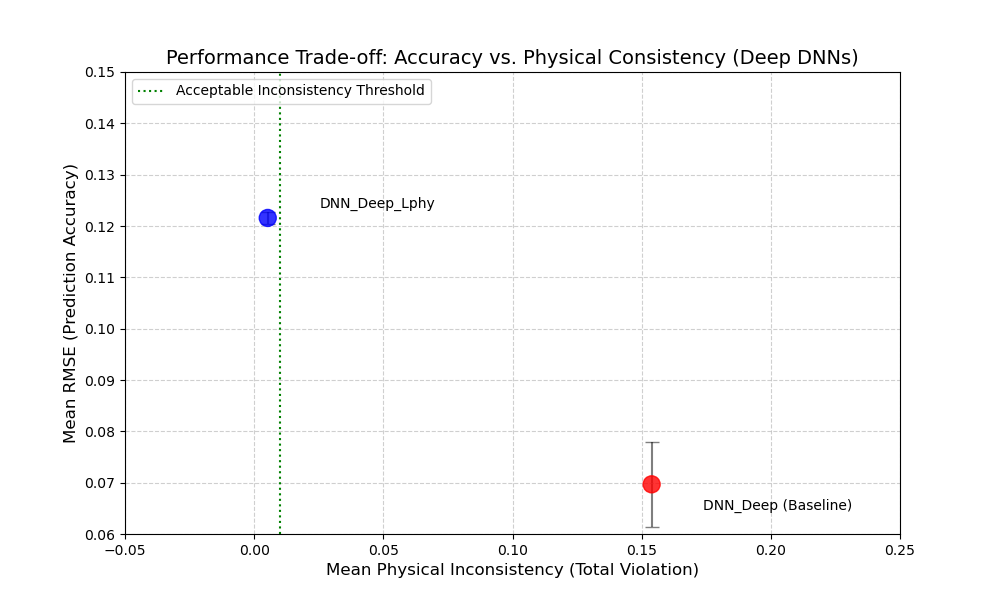

In [19]:
from IPython.display import Image
import os

# Define the file path
plot_filename = 'btp_final_tradeoff_plot.png'

# Check if the file exists before displaying
if os.path.exists(plot_filename):
    print("Displaying the generated plot:")
    display(Image(filename=plot_filename))
else:
    print(f"Error: The file '{plot_filename}' was not found in the current directory.")